# Trabalho 2 - Datastream

Considere o problema de fluxo de dados estudado nas últimas aulas, bem como o este notebook, incluindo o **baseline** e o **topline** para implementar opções alternativas a essas duas abordagens para os seguinte cenários:

+ Latência nula, isto é, tão logo a classificação é realizada o rótulo verdadeiro é disponibilizado. Portanto, neste cenário é possível utilizar métodos supervisionados para realizar a detecção de mudança de conceito;

+ Latência extrema, neste caso, os rótulos das instâncias não são disponibilizados. Portanto, a identificação da mudança de conceito deverá ser realizada sem a presença de rótulos. Somente após a detecção os rótulos das instâncias poderão ser solicitados, considerando uma janela W. Ou seja, poderá incluir todas as instâncias do fluxo a partir de t -|W|:|t|. **Você também poderá usar alguma outra configuração de janela**.

Por fim, a entrega deverá envolver datasets disponíveis no Teams que permita a adequada comparação entre as soluções e o **baseline** e o **topline** para cada cenário. 

In [8]:
# debugger
import pdb

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


## data loading

In [9]:
import pandas as pd

df_train = pd.read_csv('data/benchmark_real/Yoga_TRAIN.data')
df_test = pd.read_csv('data/benchmark_real/Yoga_TEST.data')

# rename last column to 'target'
df_train.rename(columns={df_train.columns[-1]: 'target'}, inplace=True)
df_test.rename(columns={df_test.columns[-1]: 'target'}, inplace=True)

display(df_train.head())
display(df_test.head())


,-0.074815,-0.099987,-0.12415,-0.14727,-0.16934,-0.19031,-0.21018,-0.2289,-0.24646,-0.26284,...,-0.22248,-0.21588,-0.19327,-0.14695,-0.10947,-0.095929,-0.080018,-0.061776,-0.061776.1,target
0,0.96769,0.95594,0.94516,0.87896,0.86663,0.85866,0.85172,0.84579,0.84090,0.83703,...,0.81326,0.86449,0.89717,0.93158,0.96224,0.94772,0.98331,0.96656,0.96656,1
1,0.96092,0.92833,0.89653,0.86557,0.83554,0.80644,0.77847,0.75142,0.72531,0.70034,...,1.21390,1.21600,1.22380,1.20910,1.16900,1.12970,1.09100,1.05310,1.02980,2
2,1.90820,1.87050,1.83370,1.79780,1.76290,1.72910,1.69640,1.63020,1.55850,1.52850,...,1.86160,1.88460,1.92150,1.95580,1.96770,1.98210,1.98310,1.95300,1.96270,2
3,2.01670,1.98640,1.95650,1.92720,1.89880,1.87080,1.84360,1.81720,1.79120,1.76620,...,1.82520,1.88040,1.90540,1.93240,1.98900,2.02130,2.03550,2.00030,2.00030,1
4,0.85663,0.83063,0.84637,0.90310,0.93856,0.96055,0.98312,1.00630,1.02990,1.05420,...,0.28735,0.33374,0.39324,0.44643,0.50221,0.56688,0.63181,0.68752,0.68752,1


,0.71303,0.71253,0.71299,0.66199,0.65729,0.61312,0.6057,0.61113,0.57732,0.52818,...,0.4339,0.49006,0.54338,0.59004,0.62622,0.61866,0.61918,0.66582,0.66582.1,target
0,1.60470,1.59760,1.59090,1.58460,1.57870,1.57320,1.56830,1.56380,1.5597,1.55600,...,1.18890,1.22850,1.26810,1.30780,1.34740,1.38670,1.41880,1.45420,1.47910,2
1,2.22690,2.23330,2.24030,2.24800,2.25640,2.21280,2.16650,2.11550,2.0593,2.00320,...,1.60430,1.66140,1.71850,1.77560,1.83280,1.88990,1.94710,2.00420,2.06390,1
2,1.59230,1.59920,1.60690,1.61540,1.61970,1.58100,1.58770,1.55080,1.5523,1.51730,...,1.05450,1.11140,1.16830,1.22530,1.28340,1.34060,1.39280,1.40210,1.40440,2
3,0.86213,0.85656,0.85257,0.85015,0.84931,0.85004,0.85236,0.85625,0.8617,0.80284,...,0.81818,0.80008,0.84231,0.82237,0.80391,0.78695,0.77152,0.75898,0.75898,1
4,0.95983,1.00170,1.04380,1.08600,1.12850,1.17110,1.21390,1.25680,1.2999,1.34310,...,0.40322,0.46847,0.53391,0.59066,0.61301,0.64184,0.70391,0.72783,0.72783,1


In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# separate the data into features and target variable
X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]

y_train = df_train.iloc[:,-1]
y_test = df_test.iloc[:,-1]

display(X_train.head())
display(y_train.head())


,-0.074815,-0.099987,-0.12415,-0.14727,-0.16934,-0.19031,-0.21018,-0.2289,-0.24646,-0.26284,...,-0.24712,-0.22248,-0.21588,-0.19327,-0.14695,-0.10947,-0.095929,-0.080018,-0.061776,-0.061776.1
0,0.96769,0.95594,0.94516,0.87896,0.86663,0.85866,0.85172,0.84579,0.84090,0.83703,...,0.75879,0.81326,0.86449,0.89717,0.93158,0.96224,0.94772,0.98331,0.96656,0.96656
1,0.96092,0.92833,0.89653,0.86557,0.83554,0.80644,0.77847,0.75142,0.72531,0.70034,...,1.25130,1.21390,1.21600,1.22380,1.20910,1.16900,1.12970,1.09100,1.05310,1.02980
2,1.90820,1.87050,1.83370,1.79780,1.76290,1.72910,1.69640,1.63020,1.55850,1.52850,...,1.80560,1.86160,1.88460,1.92150,1.95580,1.96770,1.98210,1.98310,1.95300,1.96270
3,2.01670,1.98640,1.95650,1.92720,1.89880,1.87080,1.84360,1.81720,1.79120,1.76620,...,1.77030,1.82520,1.88040,1.90540,1.93240,1.98900,2.02130,2.03550,2.00030,2.00030
4,0.85663,0.83063,0.84637,0.90310,0.93856,0.96055,0.98312,1.00630,1.02990,1.05420,...,0.24107,0.28735,0.33374,0.39324,0.44643,0.50221,0.56688,0.63181,0.68752,0.68752


0    1
1    2
2    2
3    1
4    1
Name: target, dtype: int64

## tqdm progress bar for parallelized processing

In [11]:
import contextlib
from tqdm import tqdm
import joblib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


## baseline model

In [12]:
from tqdm import tqdm

base_accs = np.zeros(len(y_test))

# create random forest classifier
clf = RandomForestClassifier(n_estimators=200)
# fit the model to the training data
clf.fit(X_train, y_train)

# predict the whole test data
for i in tqdm(range(0, len(y_test))):
    prediction = clf.predict(X_test.iloc[[i]])
    if prediction == y_test[i]:
        base_accs[i] = 1

base_mean_acc = np.mean(base_accs)*100

display(base_mean_acc, base_accs)

print("mean accuracy", base_mean_acc)
print("accuracies", base_accs)


100%|██████████| 2999/2999 [00:42<00:00, 71.35it/s]


56.285428476158714

array([1., 1., 1., ..., 0., 0., 0.])

mean accuracy 56.285428476158714
accuracies [1. 1. 1. ... 0. 0. 0.]


## topline model (sliding window)

In [20]:
top_accs = np.zeros(len(y_test))

window_length = 500

# create random forest classifier
clf = RandomForestClassifier(n_estimators=200)
# fit the model to the training data
clf.fit(X_train, y_train)

# predict the test data within sliding window
for i in tqdm(range(0, window_length), desc='predicting from training data'):
    prediction = clf.predict(X_test.iloc[[i]]) 
    if prediction == y_test[i]:
        top_accs[i] = 1

# predict the test data after sliding window
def predict_current(i, clf, X_test, y_test, top_accs):
    # fit the model to the test data in the sliding window
    X_window = X_test.iloc[i-window_length:i]
    y_window = y_test.iloc[i-window_length:i]
    clf.fit(X_window, y_window)
    # predict the current point
    prediction = clf.predict(X_test.iloc[[i]])
    # if the prediction is correct, add 1 to the top_accs array
    if prediction == y_test[i]:
        top_accs[i] = 1

    top_accs[i] = 1

# run the predict_current function parallelized in a tqdm progress bar
with tqdm_joblib(tqdm(range(window_length, len(y_test)), desc="predicting from sliding window")) as progress_bar:
    joblib.Parallel(n_jobs=-1)(joblib.delayed(predict_current)(i, clf, X_test, y_test, top_accs) for i in progress_bar)

top_mean_acc = np.mean(top_accs)*100

print("mean accuracy", top_mean_acc)
print("accuracies", top_accs)


predicting from sliding window: 100%|██████████| 2499/2499 [04:18<00:00,  9.67it/s]


mean accuracy 13.571190396798933
accuracies [1. 1. 1. ... 0. 0. 0.]


## Zero Latency Model

In [14]:
from river import stream, preprocessing, drift
from tqdm import tqdm

zero_accs = np.zeros(len(y_test))

window_size = 500
kswin = drift.KSWIN(window_size=500, alpha=0.0001, seed=42)

clf = RandomForestClassifier(n_estimators=200)

# fit the model to the training data
clf.fit(X_train, y_train)

# zero latency stream model training
for i, val in tqdm(enumerate(stream.iter_pandas(X_test, y_test)), desc='training stream model', total=len(y_test)):
    xi, yi = val

    X_current = pd.DataFrame([xi])
    y_current = pd.Series(yi)

    # check prediction accuracy
    acc = int(clf.predict(X_current) == y_current)
    in_drift, _ = kswin.update(acc)

    # update zero_accs array
    zero_accs[i] = acc

    # if the model is in drift, retrain the model
    if in_drift:
        print(f"Drift detected at index {i}")
        kswin.reset()  # Good practice to reset the model when a change is detected

        print("Retraining model...")        
        # retrain model on the current data from the window
        X_window = X_test.iloc[i-window_size:i]
        y_window = y_test.iloc[i-window_size:i]

        clf.fit(X_window, y_window)

zero_mean_acc = np.mean(zero_accs)*100

print("mean accuracy", zero_mean_acc)
print("accuracies", zero_accs)


training stream model:  45%|████▍     | 1342/2999 [00:26<00:31, 52.49it/s]

Drift detected at index 1346
Retraining model...


training stream model: 100%|██████████| 2999/2999 [00:58<00:00, 51.34it/s]

mean accuracy 79.49316438812937
accuracies [1. 1. 1. ... 1. 1. 1.]


## Extreme Latency Model

In [15]:
from river import stream, preprocessing, drift
from tqdm import tqdm

extr_accs = np.zeros(len(y_test))

window_size = 500
kswin = drift.KSWIN(window_size=500, alpha=0.0001, seed=42)

clf = RandomForestClassifier(n_estimators=200)

# fit the model to the training data
clf.fit(X_train, y_train)

# zero latency stream model training
for i, val in tqdm(enumerate(stream.iter_pandas(X_test, y_test)), desc='training stream model', total=len(y_test)):
    xi, yi = val

    X_current = pd.DataFrame([xi])
    y_current = pd.Series(yi)

    # check prediction accuracy
    pred = int(clf.predict(X_current))
    in_drift, _ = kswin.update(pred)

    # update extr_accs array
    extr_accs[i] = pred == y_current

    # if the model is in drift, retrain the model
    if in_drift:
        print(f"Drift detected at index {i}")
        kswin.reset()  # Good practice to reset the model when a change is detected

        print("Retraining model...")        
        # retrain model on the current data from the window
        X_window = X_test.iloc[i-window_size:i]
        y_window = y_test.iloc[i-window_size:i]

        clf.fit(X_window, y_window)

extr_mean_acc = np.mean(extr_accs)*100

print("mean accuracy", extr_mean_acc)
print("accuracies", extr_accs)


training stream model:  35%|███▌      | 1050/2999 [00:19<00:37, 51.88it/s]

Drift detected at index 1053
Retraining model...


training stream model: 100%|██████████| 2999/2999 [00:57<00:00, 51.72it/s]

mean accuracy 70.15671890630209
accuracies [1. 1. 1. ... 0. 1. 1.]


## Plotting results

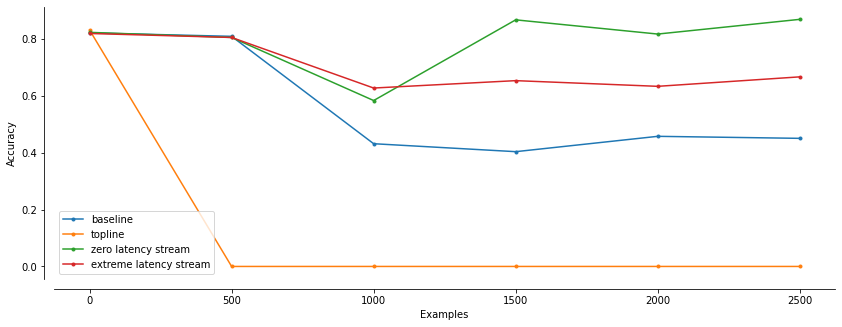

In [18]:
import matplotlib.pyplot as plt

base_mean_acc = []
top_mean_acc = []
zero_mean_acc = []
extr_mean_acc = []
for i in range(0, len(base_accs), window_size):
    base_mean_acc.append(np.mean(base_accs[i:i+window_size]))
    top_mean_acc.append(np.mean(top_accs[i:i+window_size]))
    zero_mean_acc.append(np.mean(zero_accs[i:i+window_size]))
    extr_mean_acc.append(np.mean(extr_accs[i:i+window_size]))

fig, ax = plt.subplots(figsize=(14, 5))
plt.plot([float(x)*window_size for x in range(0, len(base_mean_acc))],
         base_mean_acc, marker='.', label='baseline')
plt.plot([float(x)*window_size for x in range(0, len(top_mean_acc))],
         top_mean_acc, marker='.', label='topline')
plt.plot([float(x)*window_size for x in range(0, len(zero_mean_acc))],
         zero_mean_acc, marker='.', label='zero latency stream')
plt.plot([float(x)*window_size for x in range(0, len(extr_mean_acc))],
         extr_mean_acc, marker='.', label='extreme latency stream')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

plt.xlabel('Examples')
plt.ylabel('Accuracy')
plt.legend()
